In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [43]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2019-12').dropna()
df = web.DataReader(['UMCSENT', 'IPGMFN', 'TOTBUSSMSA'], 'fred', '1980', '2019-12').dropna()
df.columns = ['sentiment', 'ip', 'business_sales']
# df.columns = ['sentiment', 'ip']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 1992-01-01 to 2019-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sentiment       336 non-null    float64
 1   ip              336 non-null    float64
 2   business_sales  336 non-null    float64
dtypes: float64(3)
memory usage: 10.5 KB


In [44]:
df

,sentiment,ip,business_sales
DATE,,,
1992-01-01,67.5,56.8990,517626.0
1992-02-01,68.8,58.5480,520289.0
1992-03-01,76.0,59.9111,530715.0
1992-04-01,77.2,59.4885,533290.0
1992-05-01,79.2,60.3585,536742.0
...,...,...,...
2019-08-01,89.8,100.9667,1439429.0
2019-09-01,93.2,99.8213,1432497.0
2019-10-01,95.5,99.2675,1423627.0


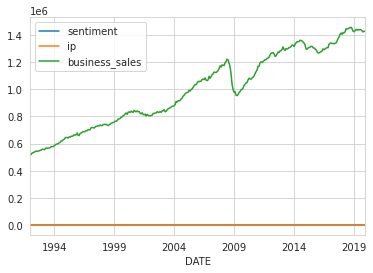

In [45]:
# 이 2개의 시계열을 한번에 모델링 해서
# 2개의 시계열을 각각 예측
df.plot()

Stationarity

In [46]:
df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12),
                                'sentiment': df.sentiment.diff(12),
                                'business_sales': np.log(df.business_sales).diff(12)
                                }
                               )
                  .dropna())

Scaling

In [47]:
### MIN-MAX Scale을 scaler를 통해 수행

scaler = MinMaxScaler(feature_range = (0,1))
df_transformed[df_transformed.columns] = scaler.fit_transform(df_transformed)

변환과정 수행 후에도 데이터가 비정상
=> RNN에 데이터를 넣어도 모델링이 안됨
=> RNN은 앞 뒤 관계를 통해서 미래를 맞춤.
=> RNN을 쓰기 위해서는 앞 뒤 관계가 명확한 데이터를 넣어주어야 한다.

In [48]:
df_transformed

,ip,sentiment,business_sales
DATE,,,
1993-01-01,0.863696,1.000000,0.858505
1993-02-01,0.848003,0.921569,0.841181
1993-03-01,0.804778,0.766667,0.767889
1993-04-01,0.806502,0.737255,0.784423
1993-05-01,0.779881,0.594118,0.804196
...,...,...,...
2019-08-01,0.601447,0.447059,0.616062
2019-09-01,0.575097,0.437255,0.600143
2019-10-01,0.569916,0.511765,0.573455


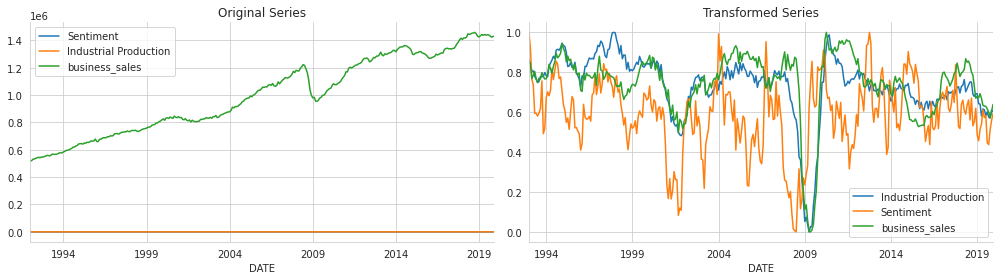

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
columns={'ip': 'Industrial Production', 'sentiment': 'Sentiment', 'business_sales': 'business_sales' }
df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Transformed Series')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'multi_rnn', dpi=300)

In [13]:
#                Times Series Analysis
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(df[['sentiment', 'ip']], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0441  , p=0.8337  , df_denom=476, df_num=1
ssr based chi2 test:   chi2=0.0444  , p=0.8331  , df=1
likelihood ratio test: chi2=0.0444  , p=0.8331  , df=1
parameter F test:         F=0.0441  , p=0.8337  , df_denom=476, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1598  , p=0.8523  , df_denom=473, df_num=2
ssr based chi2 test:   chi2=0.3230  , p=0.8509  , df=2
likelihood ratio test: chi2=0.3229  , p=0.8509  , df=2
parameter F test:         F=0.1598  , p=0.8523  , df_denom=473, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2330  , p=0.8734  , df_denom=470, df_num=3
ssr based chi2 test:   chi2=0.7094  , p=0.8710  , df=3
likelihood ratio test: chi2=0.7089  , p=0.8711  , df=3
parameter F test:         F=0.2330  , p=0.8734  , df_denom=470, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1189  , p=0.3469  

{1: ({'ssr_ftest': (0.04413910185033143, 0.8336849231096777, 476.0, 1),
   'ssr_chi2test': (0.0444172894670352, 0.8330791591125822, 1),
   'lrtest': (0.04441523020432214, 0.8330829715784205, 1),
   'params_ftest': (0.04413910185093551, 0.8336849231085983, 476.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.15981288713306083, 0.8523492525295662, 473.0, 2),
   'ssr_chi2test': (0.3230044822393365, 0.8508646245737914, 2),
   'lrtest': (0.322895397596767, 0.8509110339711414, 2),
   'params_ftest': (0.15981288713321617, 0.8523492525294093, 473.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.23299425267377705, 0.873390735537188, 470.0, 3),
   'ssr_chi2test': (0.7093931395237766, 0.8709923954892307, 3),
   'lrtest': (0.7088661581415181, 0.8711165843400713, 3),
   'params_ftest': (0.23299425267408003, 0.8733907355369667, 470.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

In [14]:
from statsmodels.tsa.stattools import coint

In [15]:
coint(df['sentiment'], df['ip'], maxlag=12)

(-2.825960706400411,
 0.15756420810803445,
 array([-3.91945022, -3.34891569, -3.05331613]))

In [50]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [51]:
window_size = 20 # step window

In [52]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

In [53]:
X.shape

(304, 20, 3)

In [54]:
y.shape

(304, 3)

In [55]:
df

,sentiment,ip,business_sales
DATE,,,
1992-01-01,67.5,56.8990,517626.0
1992-02-01,68.8,58.5480,520289.0
1992-03-01,76.0,59.9111,530715.0
1992-04-01,77.2,59.4885,533290.0
1992-05-01,79.2,60.3585,536742.0
...,...,...,...
2019-08-01,89.8,100.9667,1439429.0
2019-09-01,93.2,99.8213,1432497.0
2019-10-01,95.5,99.2675,1423627.0


In [56]:
test_size = 24
train_size = X.shape[0]-test_size

In [57]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [58]:
y_test

,ip,sentiment,business_sales
DATE,,,
2018-01-01,0.695873,0.517647,0.778615
2018-02-01,0.729131,0.639216,0.795490
2018-03-01,0.735030,0.660784,0.802605
2018-04-01,0.763489,0.607843,0.815163
2018-05-01,0.702227,0.590196,0.867848
2018-06-01,0.718547,0.635294,0.850482
2018-07-01,0.736448,0.660784,0.856167
2018-08-01,0.751626,0.560784,0.836555
2018-09-01,0.750812,0.670588,0.800990


In [59]:
X_train.shape, X_test.shape

((280, 20, 3), (24, 20, 3))

In [60]:
K.clear_session()

In [61]:
n_features = 3
output_size = 3

In [62]:
lstm_units = 200
dense_units = 128

In [63]:
rnn = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features), # 20, 3
         return_sequences=False),
    Dense(dense_units),
    Dense(output_size)
])

In [64]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               163200    
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 189,315
Trainable params: 189,315
Non-trainable params: 0
_________________________________________________________________


In [65]:
rnn.compile(loss='mse', optimizer='RMSProp')

In [66]:
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [68]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
12/14 [========================>.....] - ETA: 0s - loss: 0.1144
Epoch 1: val_loss improved from inf to 0.01068, saving model to results/multivariate_time_series/lstm.h5
14/14 [==============================] - 3s 58ms/step - loss: 0.1015 - val_loss: 0.0107
Epoch 2/100
12/14 [========================>.....] - ETA: 0s - loss: 0.0304
Epoch 2: val_loss improved from 0.01068 to 0.00674, saving model to results/multivariate_time_series/lstm.h5
14/14 [==============================] - 0s 28ms/step - loss: 0.0286 - val_loss: 0.0067
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0241
Epoch 3: val_loss did not improve from 0.00674
14/14 [==============================] - 0s 26ms/step - loss: 0.0239 - val_loss: 0.0082
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.0243
Epoch 4: val_loss improved from 0.00674 to 0.00622, saving model to results/multivariate_time_series/lstm.h5
14/14 [==============================] - 0s 29ms/step - loss: 

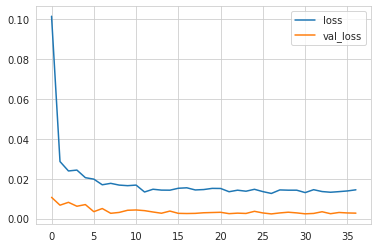

In [69]:
pd.DataFrame(result.history).plot()

In [70]:
y_pred = rnn.predict(X_test)

1/1 [==============================] - 0s 229ms/step


In [71]:
y_pred

array([[0.7364095 , 0.63385594, 0.7716658 ],
       [0.7258617 , 0.6021838 , 0.7659683 ],
       [0.72725713, 0.6091491 , 0.76587534],
       [0.72933614, 0.6189233 , 0.7662708 ],
       [0.7313192 , 0.614877  , 0.7697675 ],
       [0.730217  , 0.606091  , 0.77443784],
       [0.7310525 , 0.6104851 , 0.7759954 ],
       [0.7344862 , 0.6202717 , 0.7786499 ],
       [0.7310089 , 0.60446787, 0.7778835 ],
       [0.7308209 , 0.61809176, 0.7723017 ],
       [0.7150792 , 0.5932163 , 0.7595761 ],
       [0.6978394 , 0.5814017 , 0.7404128 ],
       [0.6842214 , 0.59023523, 0.71896976],
       [0.66742134, 0.5672749 , 0.7039235 ],
       [0.6487026 , 0.54497564, 0.6884562 ],
       [0.6395026 , 0.5447342 , 0.680483  ],
       [0.6268046 , 0.5500255 , 0.6672351 ],
       [0.6221921 , 0.57308877, 0.6564901 ],
       [0.6173849 , 0.5819126 , 0.64897776],
       [0.6130401 , 0.59000087, 0.6427405 ],
       [0.6046722 , 0.5663958 , 0.63850206],
       [0.59508216, 0.54738474, 0.63209933],
       [0.

In [72]:
y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=['ip', 'sentiment', 'business_sales'],
                      # columns=['ip', 'sentiment'],
                      index=y_test.index)
y_pred.info()

1/1 [==============================] - 0s 27ms/step
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2018-01-01 to 2019-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              24 non-null     float32
 1   sentiment       24 non-null     float32
 2   business_sales  24 non-null     float32
dtypes: float32(3)
memory usage: 480.0 bytes


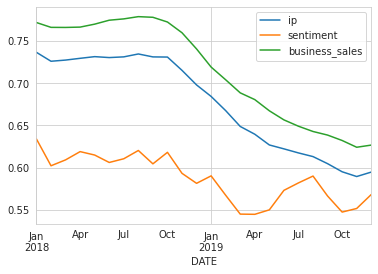

In [73]:
y_pred.plot()

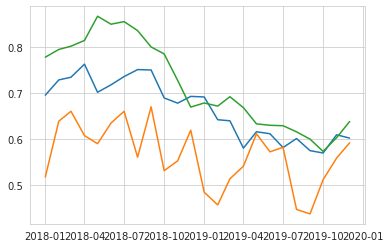

In [74]:
plt.plot(y_test)

In [75]:
test_mae = mean_absolute_error(y_pred, y_test)

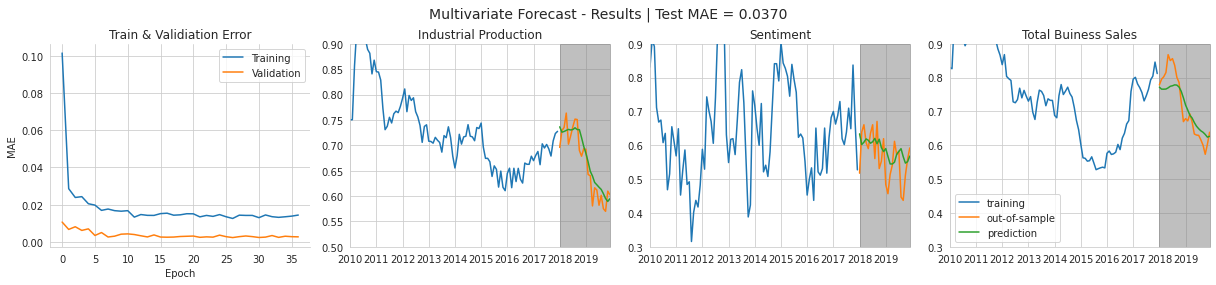

In [77]:
fig, axes = plt.subplots(ncols=4, figsize=(17, 4))
pd.DataFrame(result.history).rename(columns={'loss': 'Training',
                                              'val_loss': 'Validation'}).plot(ax=axes[0], title='Train & Validiation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
col_dict = {'ip': 'Industrial Production', 'sentiment': 'Sentiment', 'business_sales': 'Total Buiness Sales'}
# col_dict = {'ip': 'Industrial Production', 'sentiment': 'Sentiment'}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2010':, col].plot(ax=axes[i], label='training', title=col_dict[col])
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_test.index, y1=0.5, y2=0.9, color='grey', alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_test.index, y1=0.3, y2=0.9, color='grey', alpha=.5)

axes[3].set_ylim(.3, .9)
axes[3].fill_between(x=y_test.index, y1=0.3, y2=0.9, color='grey', alpha=.5)

plt.legend()
fig.suptitle('Multivariate Forecast - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'multivariate_results', dpi=300);